# XY-calibration (QSO)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe



| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
CEg = 1.0187 # CEg = 1.02928 # 2018
Elg = 1.0090 # Elg = 1.00379 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "QSO"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F3_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-QSO_-100.5.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib 
# G2UV = Guider2UV(filename=previous_xy_mapping)
# #changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.038940*u.deg, 1.394590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
		
	
# # eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.mask_rotation = 0.0*u.arcmin
# G2UV.FieldP.gamma = 1. 
# G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")



## Alternative initialisation for new fields:
---------------------------------------

In [5]:

f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# get FOVcenter & guider wcs from another field
#  put pkl from a functionning mapping from another field
G2UVother = Guider2UV(filename=previous_xy_mapping)
FOVcenter = G2UVother.FOV_center_guider_coord
guider_wcs = G2UVother.GuiderP.w
G2UV = Guider2UV(Field_center=Field_center,
                 Field_rotation= f_rot * u.deg,
                 Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
                 FOVcenter_guider_coord=FOVcenter,
                 guider_wcs = guider_wcs,
                 )
                 


FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.18212015, -0.00658703)>
FOV center pixel position in guider [array(1356.48459465), array(515.54397687)]


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.6,1.4])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

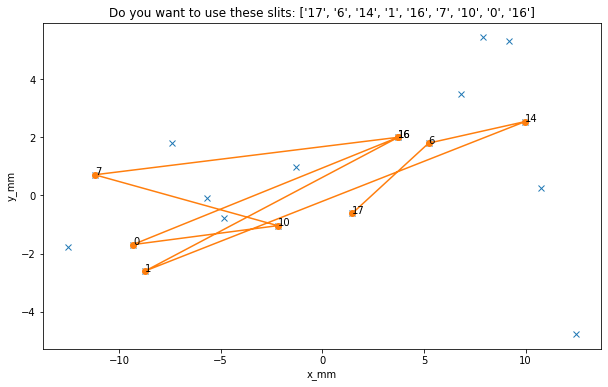

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
17,1.4615027187835672,-0.6202302818514861,22.45386,0.59717,-372.0397917012561,-83.9160000000002,381.386289298808
6,5.226252100742708,1.798431981021356,22.55721,0.62048,80259.99347189153,-3148.164,80321.71243617113
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-782.5319292155341,13.428000000000003,782.6471308487534
10,-2.197612879210593,-1.0379506376223713,14.581879999999998,-0.0281,-1213381.354398507,6722.007912,1213399.9738718986
0,-9.3221927436972,-1.689798368899516,351.63229675699995,-1.89532442,1212265.1211346844,-7064.763911999999,1212285.7067576204
16,3.734748022927276,2.000933456045201,14.70766,0.06711,0.0,0.0,0.0


In [7]:
slits =['17', '6', '14', '1', '16', '7',"10","0","16"]
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()
moves 
# if ~Hysteresis_compensation:
#     print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
#     print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [ 1.46150272 -0.62023028]
slit position in mm on mask: [5.2262521  1.79843198]
slit position in mm on mask: [9.97879885 2.54172577]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [-2.19761288 -1.03795064]
slit position in mm on mask: [-9.32219274 -1.68979837]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 300.3 arcsec ; CE: 72.0 arcsec
EL: 402.9 arcsec ; CE: 227.9 arcsec
EL: 434.6 arcsec ; CE: 425.1 arcsec
EL: 216.3 arcsec ; CE: -349.6 arcsec
EL: 411.5 arcsec ; CE: 166.1 arcsec
EL: 356.8 arcsec ; CE: -452.7 arcsec
EL: 282.5 arcsec ; CE: -79.4 arcsec
EL: 254.8 arcsec ; CE: -374.8 arcsec
EL: 411.5 arcsec ; CE: 166.1 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,300.260314,71.999466,True,300.260314,71.999466
1,102.663237,155.884580,True,402.923551,227.884046
2,31.676095,197.222960,True,434.599645,425.107007
3,-218.281676,-774.707915,True,216.317969,-349.600908
4,195.185846,515.707994,True,411.503815,166.107085
5,-54.698129,-618.763811,True,356.805687,-452.656725
6,-74.272735,373.229554,True,282.532952,-79.427171
7,-27.751784,-295.332400,True,254.781168,-374.759571
8,156.722647,540.866656,True,411.503815,166.107085


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

NameError: name 'slits_coord_obs_det' is not defined

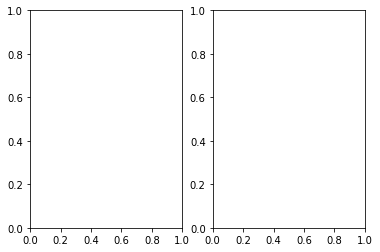

In [9]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [13]:

slits_coord_obs_det = np.array([
[ 1616.5,	1042.5 ],
[ 1778.5,	756.5  ],
[ 1830.5,	400.5  ],
[ 1494.5,	1808.9  ],
[ 1791.4,	868.4  ],
[ 1717.4,	1992.6  ],
[ 1590.5,	1316.6  ],
[ 1553.5,	1854.4  ],
[ 1791.4,	866.5  ]]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.16767546, -0.00201992)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.2267033, -0.08758828)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.24517405, -0.19696053)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.11480392, 0.22817731)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.23033261, -0.05289553)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>):

### look at siderostat frame hysteresis 

In [10]:
if Hysteresis_compensation:
    mid  = len(slits_coord_obs_det)//2
    pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
    moves_sign  = np.sign(moves[2:mid+2])
    pair_diff_signed = pair_diff * moves_sign
    valid = np.arange(len(moves_sign))#[0,2,3,4]
    fig, (ax0,ax1) = plt.subplots(1,2)
    ax0.plot(pair_diff_signed[valid,0],'*-')
    ax0.set_title("El pair diff")
    ax0.set_ylabel("El arcsec")
    ax1.plot(pair_diff_signed[valid,1],'*-')
    ax1.set_title("Ce pair diff")
    ax1.set_ylabel("Ce arcsec")
    fig.suptitle("Hysteresis analysis")
    fig.tight_layout()


## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

In [11]:
# slits_coord_obs_det
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )


NameError: name 'slits_coord_obs_det' is not defined

Fitting rotation, translation and magnification
gamma: 1.0307487897995826
theta: -99.81284102886394 arcmin
dx: -15.860852251810309 arcsec
dy: -115.91233905287919 arcsec
variances: [5.39474522e-04 1.85457680e+00 4.98305186e-01 4.98305186e-01]

residuals in arcsec: [[-0.79385976  2.97191534]
 [ 2.62209627 -0.02775604]
 [-4.30792246 -2.10280016]
 [-2.59361661 -4.62828562]
 [ 2.68407505  1.10478642]
 [ 4.42653593 -1.78818651]
 [-0.64106925  4.16403679]
 [-4.14087955  1.30645919]
 [ 2.74464039 -1.00016942]]
max residual in EL,CE 4.4, 4.6 arcsec
mean residual in EL,CE 3.1, 2.6 arcsec


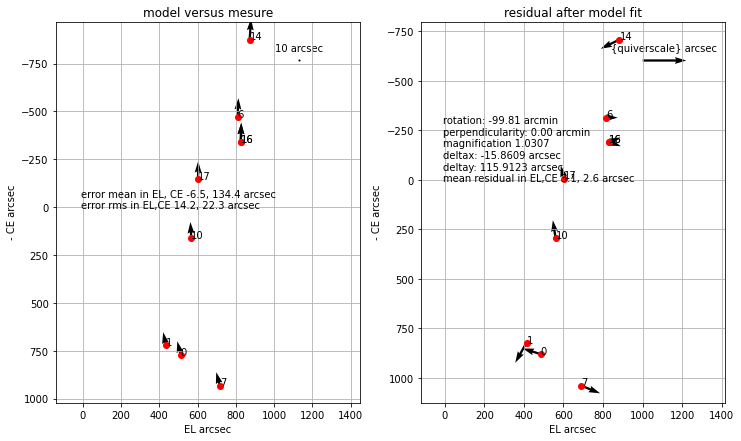

After updating:
    mask_rotation: -1.6635473504810656 deg
    FOV center in guider: 1359.6497345325663 x 369.22049070077884 pix = 659.243085520259 arcsec x -159.3906848164758 arcsec arcsec
    mask_magnification correction: 1.0307487897995826  
    


In [14]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits)


### check updating without fitting magnification

In [16]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV center in guider: 1378.693979871492x218.8622925672349 pix



Fitting rotation, translation and magnification
gamma: 1.0232833033079378
theta: -2.0637580783996947 arcmin
dx: 4.437276448568153 arcsec
dy: 143.25463394034085 arcsec
variances: [6.11843078e-04 2.10336157e+00 5.00674651e-01 5.00674651e-01]

residuals in arcsec: [[  1.9657011   -1.71084236]
 [ -0.01330166   2.84150477]
 [ -7.2949686    6.7729117 ]
 [  2.47269373  -3.13469606]
 [  2.4098009    3.81370921]
 [ -5.181121     3.22448209]
 [  5.64119552 -11.80706935]]
max residual in EL,CE 7.3, 11.8 arcsec
mean residual in EL,CE 4.3, 5.7 arcsec


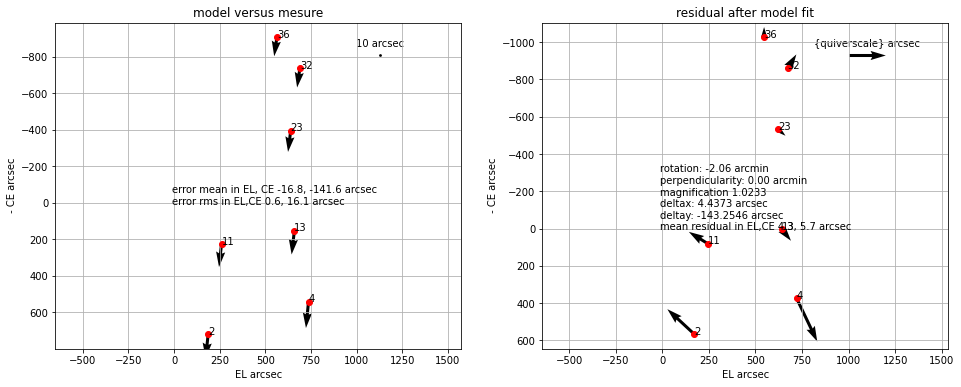

After updating:
    mask_rotation: -2.0637580783996947 arcmin
    FOV center in guider: 1398.4762460299144 x 365.8956797724491 pix = 690.9515191289703 arcsec x -162.34450625985818 arcsec arcsec
    mask_magnification correction: 1.0232833033079378  
    


In [17]:
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True)


### save corrected model for future use (eg redo the calib on same field)

In [18]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/F4_XY_220715.pkl")

Dumping to Calibration/Mappings/2022/XY/F4_XY_220715.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

slit position in mm on mask: [ 1.46150272 -0.62023028]
slit position in mm on mask: [5.2262521  1.79843198]
slit position in mm on mask: [9.97879885 2.54172577]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [-2.19761288 -1.03795064]
slit position in mm on mask: [-9.32219274 -1.68979837]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 297.8 arcsec ; CE: 140.2 arcsec
EL: 398.3 arcsec ; CE: 305.6 arcsec
EL: 424.7 arcsec ; CE: 511.9 arcsec
EL: 224.7 arcsec ; CE: -301.3 arcsec
EL: 409.0 arcsec ; CE: 241.5 arcsec
EL: 371.9 arcsec ; CE: -404.4 arcsec
EL: 284.3 arcsec ; CE: -18.0 arcsec
EL: 264.9 arcsec ; CE: -326.3 arcsec
EL: 409.0 arcsec ; CE: 241.5 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_68075/3419102104.py:14: RuntimeWarning: divide by zero encountered in true_divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_68075/3419102104.py:15: RuntimeWarning: divide by zero encountered in true_divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_68075/3419102104.py:16: RuntimeWarning: divide by zero encountered in true_divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


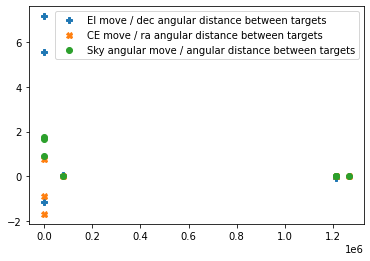

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
17,1.4615027187835672,-0.6202302818514861,22.45386,0.59717,-372.0397917012561,-83.9160000000002,381.386289298808,297.7919974695289,140.23705464268224,600.9442508935092,285.7189751290008,665.4091413789921,1.7447117530165284,-7.161259484407119,-0.7679796126711899
6,5.226252100742708,1.798431981021356,22.55721,0.62048,80259.99347189153,-3148.164,80321.71243617113,100.4764222565919,165.3606394294101,202.76142011380244,336.90576677348014,393.2145586976562,0.004895495212581904,-0.0644062444376476,0.004197679967311118
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013,26.42875653378569,206.30302667371635,53.33323068517952,420.3217865450297,423.6919137058484,0.00033503605079030554,0.0043422894454262,-0.00033238678652692795
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966,-200.04027652503973,-813.1550312664975,-403.68127802753014,-1656.722060702362,1705.193995018696,0.0014065510815725658,0.05652225927447474,-0.0013665921009613944
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643,184.3027561672958,542.7788706010771,371.9229619456029,1105.8576709626343,1166.7252795963977,0.9125854098936419,1.1293390235437097,0.8951854789272107
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-782.5319292155341,13.428000000000003,782.6471308487534,-37.10665977405397,-645.9280310236535,-74.88123942404091,-1316.0137704075914,1318.1424217132553,1.6842103800773869,-5.576499808165095,1.681738113519352
10,-2.197612879210593,-1.0379506376223713,14.581879999999998,-0.0281,-1213381.354398507,6722.007912,1213399.9738718986,-87.59295146857987,386.4375531522258,-176.76257606359417,787.3278707923448,806.9263810429333,0.0006650126903069493,-0.026296097591322527,-0.0006488709159229138
0,-9.3221927436972,-1.689798368899516,351.63229675699995,-1.89532442,1212265.1211346844,-7064.763911999999,1212285.7067576204,-19.3970179638917,-308.34643890739517,-39.143182251133446,-628.2250346299269,629.4433118657456,0.0005192202699058911,0.0055406214190181205,-0.0005182241274432659
16,3.734748022927276,2.000933456045201,14.70766,0.06711,0.0,0.0,0.0,144.09662920652553,567.8369167788228,290.7869977387685,1156.9109342451734,1192.895631574685,inf,inf,inf


In [27]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_pandas().to_clipboard()
moves

# # new_cat = slit_path[:9]
# new_cat["EL"] = moves["EL"][:]
# new_cat["CE"] = moves["CE"][:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()

# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

Fitting rotation, translation and magnification
gamma: 0.9934876542772411
theta: 66.27481528137125 arcmin
dx: -2.381498379197922 arcsec
dy: -17.052132923034883 arcsec
variances: [5.39474522e-04 1.85457680e+00 4.98305186e-01 4.98305186e-01]

residuals in arcsec: [[ -2.83665848  -2.38360588]
 [  3.60690433  -2.05288506]
 [ -2.71167861  -5.12662037]
 [ 49.89932748   3.95095895]
 [  1.81211867   1.61518766]
 [-22.28911316  -1.33853714]
 [ -9.22466124   2.03998768]
 [-20.19401981   1.67463414]
 [  1.93778085   1.62088002]]
max residual in EL,CE 49.9, 5.1 arcsec
mean residual in EL,CE 19.8, 2.7 arcsec


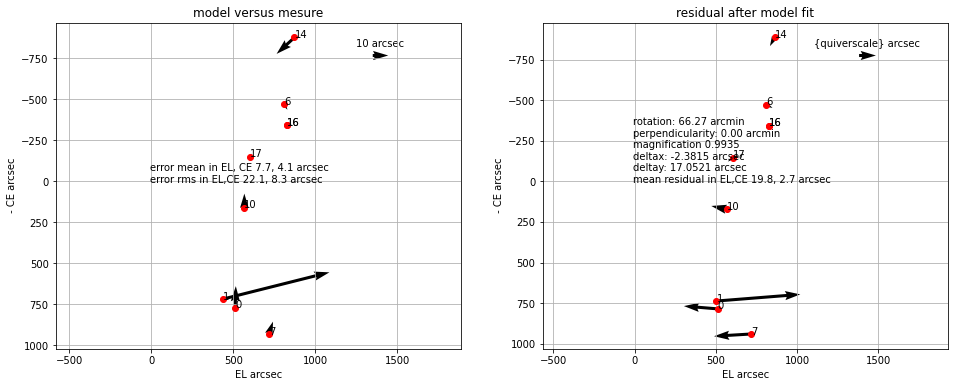

After updating:
    mask_rotation: -0.5589670957915449 deg
    FOV center in guider: 1355.824871340254 x 365.6054509688707 pix = 655.6411914995867 arcsec x -162.6955516020288 arcsec arcsec
    mask_magnification correction: 1.0240361973270924  
    


(<guider2UV.guider2UV.Guider2UV at 0x7f90a2ff5130>,
 array([[-0.00078796, -0.00066211],
        [ 0.00100192, -0.00057025],
        [-0.00075324, -0.00142406],
        [ 0.01386092,  0.00109749],
        [ 0.00050337,  0.00044866],
        [-0.00619142, -0.00037182],
        [-0.00256241,  0.00056666],
        [-0.00560945,  0.00046518],
        [ 0.00053827,  0.00045024]]))

In [13]:
slits_coord_obs_det = np.array([
[ 1612.5,	917.7  ],
[ 1772.4,	615.5 ],
[ 1817.5,	243.5  ],
[ 1560.5	,1721.4  ],
[ 1788.4,	732.5  ],
[ 1738.5	,1903.5  ],
[ 1592.6	,1205.5  ],
[ 1569.6	,1765.5  ],
[ 1788.5,	732.5  ]]) 

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(16,6), labels=slits)





## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [23]:
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"
# il faut que le centre soit bien defini à l'arcseconde pres.
F1_stars = Table.read(star_target_path).to_pandas()
stars = [2, 4, 5, 6, 7]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves
# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: 5388.4 arcsec ; CE: 14741.8 arcsec
EL: 5448.4 arcsec ; CE: 14623.4 arcsec
EL: 5461.9 arcsec ; CE: 14634.3 arcsec
EL: 5613.7 arcsec ; CE: 14680.4 arcsec
EL: 5536.4 arcsec ; CE: 14699.5 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,5388.440696,14741.824026,1.0
1,59.969388,-118.446641,1.0
2,13.507677,10.915682,1.0
3,151.820435,46.103143,1.0
4,-77.321805,19.126586,1.0


In [25]:


stars = [8, 10, 12] #QSO7
#back to guider center
#Load new 
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(22.42638*u.deg, 0.62279*u.deg), rotation=(90-70)*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()

star_moves



targets local coords in siderostat local frame:
EL: -103.9 arcsec ; CE: 122.7 arcsec
EL: -68.9 arcsec ; CE: 290.8 arcsec
EL: 271.4 arcsec ; CE: 150.7 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,-103.948283,122.691747,1.0
1,35.066957,168.066015,1.0
2,340.312946,-140.029584,1.0


In [27]:
stars = [13,14] #QSO5
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(14.62883*u.deg, 0.00512*u.deg), rotation=(90-100)*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves



targets local coords in siderostat local frame:
EL: 9.8 arcsec ; CE: 285.5 arcsec
EL: -132.1 arcsec ; CE: 8.4 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,9.772684,285.527040,1.0
1,-141.843219,-277.157354,1.0


In [28]:



stars = [17, 18, 19, 20, 21] #QSOV 14
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(351.8533*u.deg, -1.8553*u.deg), rotation=0*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves



targets local coords in siderostat local frame:
EL: 92.8 arcsec ; CE: -165.6 arcsec
EL: 265.5 arcsec ; CE: 185.7 arcsec
EL: 305.2 arcsec ; CE: 190.8 arcsec
EL: 149.4 arcsec ; CE: 234.0 arcsec
EL: 55.3 arcsec ; CE: 237.7 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,92.831469,-165.645069,1.0
1,172.692911,351.377731,1.0
2,39.715096,5.065623,1.0
3,-155.829124,43.245725,1.0
4,-94.093055,3.635582,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [22]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------